# Лабораторная работа № 4. Регрессионный анализ данных
### Степушин С.В. 19-ИВТ-2
### Вариатн - 19
#### Набор данных - 4
#### Классификаторы - 1,2
### 1.	Изучить набор данных. Создать описание набора данных на русском языке. 

#### Набор данных:

Frequency: частота (в герцах)

Angle of attack: угол атаки (в градусах)

Chord length: длина хорды (в метрах)

Free-stream velocity: скорость набегающего потока (в метрах в секунду)

Suction side displacement thickness: толщина вытеснения на стороне всасывания (в метрах)

Scaled sound pressure level: масштабируемый уровень звукового давления (в децибелах)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split)
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
nasa = pd.read_csv('airfoil_self_noise.dat.txt', sep='\s+', names=["Frequency","Angle of attack",
                                                                   "Chord length","Free-stream velocity",
                                                                   "Suction side displacement thickness",
                                                                   "Scaled sound pressure level"])

### 2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции.

In [2]:
print("Количество строк до очистки:" , len(nasa))
print("Количество строк после очистки:" , len(nasa.drop_duplicates()))

Количество строк до очистки: 1503
Количество строк после очистки: 1503


### 3.Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию).

#### Диаграммы BoxPlot до мастштабирования:

<AxesSubplot:>

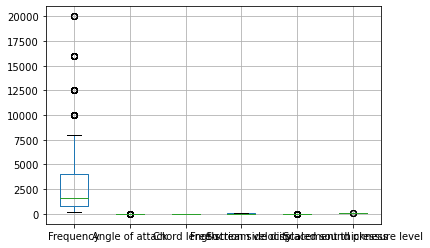

In [3]:
nasa.boxplot()

In [4]:
numerical_columns = [i for i in nasa.columns[0:6] if nasa[i].dtype.name != 'object']
categorial_columns = [i for i in nasa.columns[0:6] if nasa[i].dtype.name == 'object']
print("Числовые: ", numerical_columns)
print("Категориальные : ", categorial_columns)

Числовые:  ['Frequency', 'Angle of attack', 'Chord length', 'Free-stream velocity', 'Suction side displacement thickness', 'Scaled sound pressure level']
Категориальные :  []


В качестве способа масштабирования выберем нормализацию.

In [5]:
normal = MinMaxScaler()
nasa[numerical_columns] = normal.fit_transform(nasa[numerical_columns])
nasa.head()

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness,Scaled sound pressure level
0,0.030303,0.0,1.0,1.0,0.039005,0.606829
1,0.040404,0.0,1.0,1.0,0.039005,0.580238
2,0.053030,0.0,1.0,1.0,0.039005,0.600181
3,0.070707,0.0,1.0,1.0,0.039005,0.643790
4,0.090909,0.0,1.0,1.0,0.039005,0.640333


#### Диаграммы BoxPlot после мастштабирования:

<AxesSubplot:>

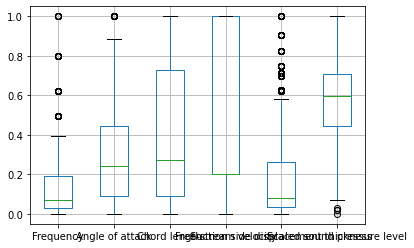

In [6]:
nasa.boxplot()

### 4.	Выполните замену категориальных признаков; выберите и обоснуйте способ замены
В нашем случае замена не нужна, потому что категориальные признаки отсутствуют.

### 5.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других

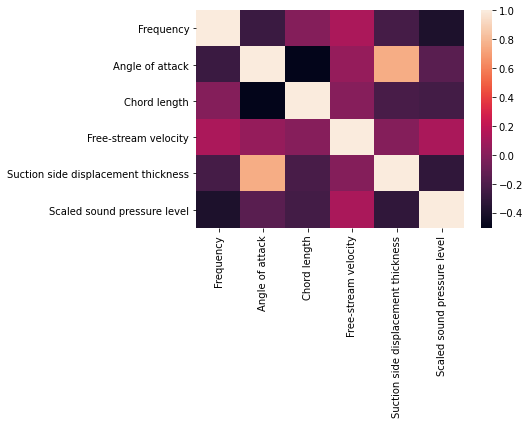

In [7]:
sns.heatmap(nasa.corr());

In [8]:
nasa.corr()

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness,Scaled sound pressure level
Frequency,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
Angle of attack,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
Chord length,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
Free-stream velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
Suction side displacement thickness,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
Scaled sound pressure level,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


Можно увидеть, что угол атаки сильно коррелирует с длиной хороды, скоростью набегающего потока и толщиной вытеснения. Поэтому удалим его.

In [9]:
nasa.drop('Angle of attack', axis=1, inplace=True)

### 6. Заполните пропущенные значения в данных.
Количество строк:

In [10]:
len(nasa)

1503

Теперь посмотрим есть ли пропущенные значения.

In [11]:
nasa.count()

Frequency                              1503
Chord length                           1503
Free-stream velocity                   1503
Suction side displacement thickness    1503
Scaled sound pressure level            1503
dtype: int64

#### Пропущенных значений нет.

### 7. Решите поставленную задачу регрессии в соответствии с заданием. При подборе параметров метода принятия решения (метода регрессии) используйте перекрёстную проверку (изучите возможные для изменения параметры метода регрессии).  Вычислите точность решения задачи, вычислив разницу между реальным значением и предсказанным. Вычислите коэффициент корреляции (Пирсона, Спирмена) между реальным значением и предсказанным с учётом p-value. 
Разделим полученные данные на данные для обучения и теста.

In [12]:
X = nasa.drop(['Frequency'], axis=1)
Y = nasa['Frequency']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

#### Линейная регрессия без использования регуляторов

In [13]:
regres = LinearRegression()
regres.fit(X_train,Y_train)
regres_pred = regres.predict(X_test)
print(regres_pred[:15] - Y_test[:15])

968    -0.281785
9      -0.076309
1468    0.017243
1150    0.300126
880    -0.023869
202     0.192739
122     0.005069
984     0.060965
688     0.029720
506    -0.000319
278     0.029823
1013   -0.193804
997     0.033450
432     0.070961
82      0.036182
Name: Frequency, dtype: float64


In [17]:
Person, p_value_Person = pearsonr(regres_pred, Y_test)
Spirmen, p_value_Spirmen = spearmanr(regres_pred, Y_test)

print('Погрешность:', mean_squared_error(regres_pred, Y_test))
print("Корреляция по Пирсону: ", Person," p_value :", p_value_Person)
print("Корреляция по Спирмену: ", Spirmen," p_value :", p_value_Spirmen)

Погрешность: 0.015810885789199213
Корреляция по Пирсону:  0.6276083991926913  p_value : 9.09592539810902e-51
Корреляция по Спирмену:  0.5852230397519462  p_value : 8.435225225071943e-43


#### Линейная регрессия, LASSO регуляризатор

In [21]:
lass = Lasso(alpha = 0.01)
lass.fit(X_train, Y_train)
pred_lass = lass.predict(X_test)

In [23]:
Person, p_value_Person = pearsonr(pred_lass, Y_test)
Spirmen, p_value_Spirmen = spearmanr(pred_lass, Y_test)
print('Погрешность:', mean_squared_error(regres_pred, Y_test))
print("Корреляция по Пирсону: ", Person," p_value :", p_value_Person)
print("Корреляция по Спирмену: ", Spirmen," p_value :", p_value_Spirmen)

Погрешность: 0.015810885789199213
Корреляция по Пирсону:  0.4249903535607463  p_value : 3.3172297547762667e-21
Корреляция по Спирмену:  0.359134869668993  p_value : 3.55299979538712e-15
